In [2]:
from pythtb import Lattice, TBModel
from axion import axion_angle_3form
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
lat_vecs = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
orb_vecs = [[0, 0, 0], [0.25, 0.25, 0.25]]
lat = Lattice(lat_vecs, orb_vecs, periodic_dirs=[0, 1, 2])

fkm_model = TBModel(lattice=lat, spinful=True)

t = 1.0
soc = 1/4
m = 1/2

fkm_model.set_onsite(
    lambda beta: [0, m*np.sin(beta), m*np.sin(beta), m*np.sin(beta)],
    ind_i=0,
)
fkm_model.set_onsite(
    lambda beta: [0, -m*np.sin(beta), -m*np.sin(beta), -m*np.sin(beta)],
    ind_i=1,
)

# spin-independent first-neighbor hops
for lvec in ([-1, 0, 0], [0, -1, 0], [0, 0, -1]):
    fkm_model.set_hop(t, 0, 1, lvec)

fkm_model.set_hop(
    lambda beta: 3 * t + m * np.cos(beta), 
    0, 1, [0, 0, 0], mode="set")

# spin-dependent second-neighbor hops
lvec_list = ([1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, 1, 0], [0, -1, 1], [1, 0, -1])
dir_list = ([0, 1, -1], [-1, 0, 1], [1, -1, 0], [1, 1, 0], [0, 1, 1], [1, 0, 1])
for j in range(6):
    spin = np.array([0.0] + dir_list[j])
    fkm_model.set_hop(1j * soc * spin, 0, 0, lvec_list[j])
    fkm_model.set_hop(-1j * soc * spin, 1, 1, lvec_list[j])

print(fkm_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 3
periodic directions         = [0, 1, 2]
spinful                     = True
number of spin components   = 2
number of electronic states = 4
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 0.000,  1.000,  1.000]
  # 1 ===> [ 1.000,  0.000,  1.000]
  # 2 ===> [ 1.000,  1.000,  0.000]
Volume of unit cell (Cartesian) = 2.000 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [-3.142,  3.142,  3.142]
  # 1 ===> [ 3.142, -3.142,  3.142]
  # 2 ===> [ 3.142,  3.142, -3.142]
Volume of reciprocal unit cell = 124.025 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.500,  0.500,  0.500]

Orbital vectors (fractional):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.250,  0.250,  0.250]
----------------------------------------
Site energies:


In [4]:
### Adiabatic parameters
# k space
nks = 30, 30, 30

# lambda space
n_beta = 51
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=True) 

########### Useful model information ###########
recip_lat_vecs = fkm_model.recip_lat_vecs  # Reciprocal lattice vectors (Cartesian)
n_spin = fkm_model.nspin   # Number of spins
n_orb = fkm_model.norb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

n_param = nks + (n_beta,)    # Number of points in 4d mesh
dim_k = fkm_model.dim_k      # Number of k-space dimensions (3)
dim_lam = 1                  # Number of adiabatic dimensions (1)
dim_total = dim_k + dim_lam  # Total number of dimensions (4)

print(f"Number of orbs: {n_orb}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)
print("(nks, nbeta):", n_param)
print("Total number of parameter points:", np.prod(n_param))

Number of orbs: 2
Number of spins: 2
Number of states: 4
Number of occupied bands: 2
(nks, nbeta): (30, 30, 30, 51)
Total number of parameter points: 1377000


In [5]:
betas_kubo, thetas_kubo, c2 = fkm_model.axion_angle(
    nks=nks, 
    param_periods={'beta': 2*np.pi},
    return_second_chern=True, 
    use_tensorflow=True,
    diff_order=8,
    beta=betas
)

In [7]:
thetas_3form_curv = np.zeros((betas.shape[0]))
thetas_3form_conn = np.zeros((betas.shape[0]))

for idx, beta in enumerate(betas):
    print(f"Computing theta for beta index {idx} / {betas.shape[0]-1}")
    model = fkm_model.copy()
    model.set_parameters({"beta": beta})

    # trial wavefunctions of form (orbital, spin, amp)
    # buffer zone to avoid singularity at beta = pi
    if abs(beta - np.pi) < 0.5:
        # breaks TRS in gauge to avoid topological obstruction
        tf_list = [ 
            [(0, 0, -1), (0, 1, 1)], 
            [(1, 0, 1), (1, 1, 1)]
            ]
    else:
        tf_list = [[(0, 0, 1), (1, 0, -1)], [(0, 1, 1), (1, 1, -1)]]

    theta, theta2 = axion_angle_3form(
        model, tf_list, nks=nks, return_both=True, order_fd=11,
        use_tf_speedup=True
        )
    thetas_3form_curv[idx] = theta
    thetas_3form_conn[idx] = theta2

    print(f"idx: {idx}, beta: {beta}, theta: {theta.real}, theta2: {theta2.real}")

Computing theta for beta index 0 / 50
Min singular value of S_occ: 0.87074006
idx: 0, beta: 0.0, theta: 1.3716593524872291e-09, theta2: 0.0
Computing theta for beta index 1 / 50
Min singular value of S_occ: 0.87004894
idx: 1, beta: 0.12566370614359174, theta: 0.10457176830150462, theta2: 0.10438193540219907
Computing theta for beta index 2 / 50
Min singular value of S_occ: 0.86788166
idx: 2, beta: 0.25132741228718347, theta: 0.19992496744791666, theta2: 0.19963123914930556
Computing theta for beta index 3 / 50
Min singular value of S_occ: 0.8639618
idx: 3, beta: 0.3769911184307752, theta: 0.2805414496527778, theta2: 0.28023896846064816
Computing theta for beta index 4 / 50
Min singular value of S_occ: 0.85864675
idx: 4, beta: 0.5026548245743669, theta: 0.34543601707175925, theta2: 0.3451763961226852
Computing theta for beta index 5 / 50
Min singular value of S_occ: 0.8510965
idx: 5, beta: 0.6283185307179586, theta: 0.3966862702546296, theta2: 0.3964807219328704
Computing theta for beta

In [8]:
thetas_proj_conn = np.unwrap(thetas_3form_conn)
thetas_proj_curv = np.unwrap(thetas_3form_curv)

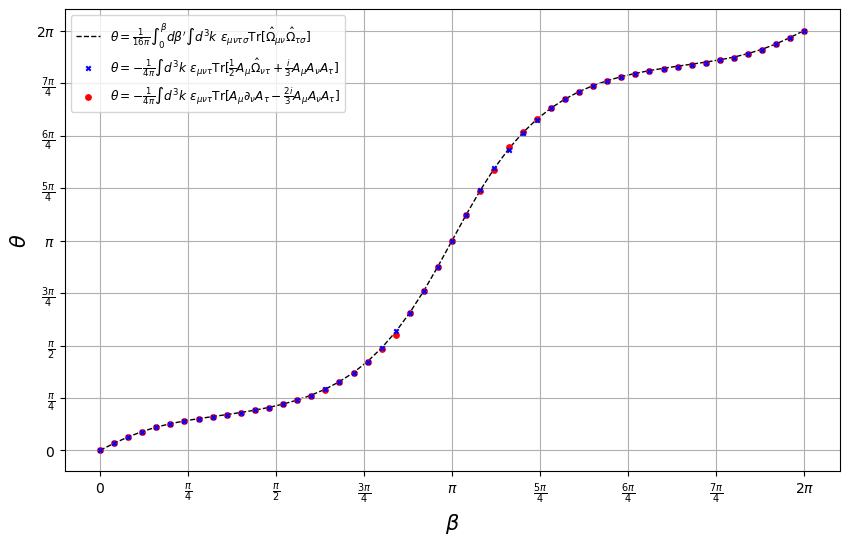

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(betas, thetas_kubo.real, lw=1, zorder=1, c='k', ls='--',
        label=r"$\theta = \frac{1}{16\pi} \int_0^{\beta}d\beta' \int d^3k\ \epsilon_{\mu\nu\tau\sigma}  \text{Tr}[\hat{\Omega}_{\mu\nu} \hat{\Omega}_{\tau\sigma}]$")  


ax.scatter(betas, thetas_proj_curv, s=10, c='b', zorder=3, marker='x',
           label=r"$\theta = -\frac{1}{4\pi} \int d^3k\ \epsilon_{\mu\nu\tau} \text{Tr} [\frac{1}{2}A_{\mu}\hat{\Omega}_{\nu\tau} + \frac{i}{3} A_\mu A_\nu A_\tau]$")

ax.scatter(betas, thetas_proj_conn, s=15, c='r', zorder=2, marker='o', 
           label=r"$\theta = -\frac{1}{4\pi} \int d^3k\ \epsilon_{\mu\nu\tau} \text{Tr} [ A_{\mu}\partial_{\nu} A_{\tau} -\frac{2i}{3} A_\mu A_\nu A_\tau]$"
           )

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

ax.grid()
ax.legend(loc='upper left', prop={'size': 8.8})
# ax.set_title(fr"$N_k = ${nks}, $C_2 = {c2:.4f}$", size=15)
plt.savefig("fkm_axion_angle_comparison.png", dpi=300)
plt.show()

In [ ]:
nkxs = [10, 20, 30, 40, 50, 75, 100, 150]

thetas_beta_pi_curv = np.zeros(len(nkxs))
thetas_beta_pi_conn = np.zeros(len(nkxs))
thetas_beta_pi_4curv = np.zeros(len(nkxs))

beta = np.pi

for idx, nkx in enumerate(nkxs):
    nks = nkx, nkx, nkx
    print(f"Processing nks = {nks} -> Nk = {nkx**3}")
    # 4-curvature
    betas_kubo, thetas_kubo, c2 = fkm_model.axion_angle(
    nks=nks, 
    param_periods={'beta': 2*np.pi},
    return_second_chern=True, 
    use_tensorflow=True,
    diff_order=1,
    beta=betas
    )

    thetas_beta_pi_4curv[idx] = thetas_kubo[np.abs(betas - np.pi).argmin()]

    # 3-form

    model = fkm_model.copy()
    model.set_parameters({"beta": beta})

    # trial wavefunctions of form (orbital, spin, amp)
    # breaks TRS in gauge to avoid topological obstruction
    tf_list = [ 
        [(0, 0, -1), (0, 1, 1)], 
        [(1, 0, 1), (1, 1, 1)]
        ]
    
    theta_curv, theta_conn = axion_angle_3form(model, tf_list, nks=nks, return_both=True, order_fd=21, use_tf_speedup=True)

    thetas_beta_pi_curv[idx] = theta_curv.real
    thetas_beta_pi_conn[idx] = theta_conn.real

Processing nks = (10, 10, 10) -> Nk = 1000
Min singular value of S_occ: 0.23462416
Processing nks = (20, 20, 20) -> Nk = 8000
Min singular value of S_occ: 0.21449365
Processing nks = (30, 30, 30) -> Nk = 27000
Min singular value of S_occ: 0.21246453
Processing nks = (40, 40, 40) -> Nk = 64000
Min singular value of S_occ: 0.21449365
Processing nks = (50, 50, 50) -> Nk = 125000
Min singular value of S_occ: 0.21227208
Processing nks = (75, 75, 75) -> Nk = 421875
Min singular value of S_occ: 0.2133204
Processing nks = (100, 100, 100) -> Nk = 1000000
Min singular value of S_occ: 0.21227208
Processing nks = (150, 150, 150) -> Nk = 3375000
Min singular value of S_occ: 0.21227208


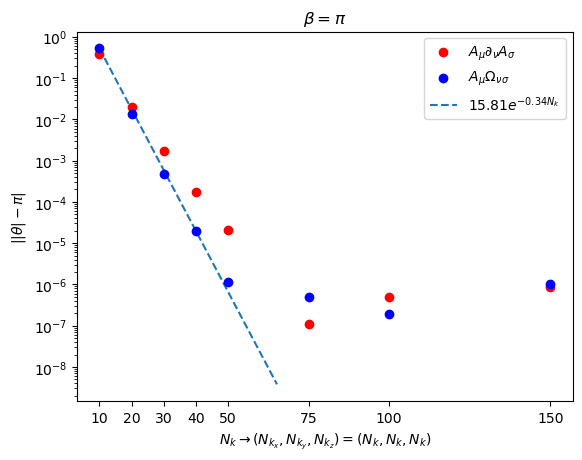

In [15]:
fig, ax = plt.subplots()

ax.scatter(nkxs[:], abs(delta_theta_conn[:]), c='r', label=r'$A_{\mu} \partial_{\nu} A_{\sigma}$')
ax.scatter(nkxs[:], abs(delta_theta_curv[:]), c='b', label=r'$A_{\mu}\Omega_{\nu\sigma}$')

# error
N = np.linspace(nkxs[0], nkxs[-1], 100)
a = 0.34
C = abs(delta_theta_curv[0])*np.exp(a*N[0])
fit = C*np.exp(-a * N)
ax.plot(N[:40], fit[:40], ls='--', label=rf'${C:.2f}e^{{-{a} N_k}}$', zorder=0)

ax.set_xlabel(r'$N_k \rightarrow (N_{k_x}, N_{k_y}, N_{k_z}) = (N_{k}, N_{k}, N_{k})$')
ax.set_ylabel(r'$| |\theta| - \pi |$')
ax.set_title(r"$\beta = \pi$")
ax.set_xticks(nkxs)

plt.yscale('log') 
plt.legend()